# Assignment 5: "No one can be told what the Ranktrix is. You have to see it for yourself."

## © Cristian Danescu-Niculescu-Mizil 2023

## CS/INFO 4300 Language and Information

### Due by 11:59PM on Friday March 03, 2023

**Instructions**

For code completion tasks, just type your code after the comment marking the place.  For questions, use as many notebook cells as needed to compute intermediate stuff.

You are strongly encouraged to write sensible **test cases** for your code.

This is an **individual** assignment.

If you use any outside sources (e.g. research papers, StackOverflow) please list your sources.

In this assignment we will explore evaluation of an information retrevial system where both queries and results are movies. Ever wanted to know what the most similar movie to "The Matrix" is, in terms of language? Now is your chance! You take the blue pill - the story ends, you wake up in your dorm on west campus and believe whatever you want to believe. You take the red pill - you stay in CS/INFO 4300 and we show you how deep the rabbit-hole goes.

**Guidelines**

* All cells that contain the blocks that read `# YOUR CODE HERE` are editable and are to be completed to ensure you pass the test-cases. Make sure to write your code where indicated.

* All cells that read `YOUR ANSWER HERE` are free-response cells that are editable and are to be completed.

* Please delete raise `NotImplementedError()` after filling in the function code. It is only meant to be a temporary placeholder

* You may use any number of notebook cells to explore the data and test out your functions, although you will only be graded on the solution itself.

* You are unable to modify the read-only cells.

* You should also use Markdown cells to explain your code and discuss your results when necessary.
Instructions can be found [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html).

* All floating point values should be printed with **2 decimal places** precision. You can do so using the built-in round function.

* **Never delete any code / free response and autograder test cell.**

* Do not delete the cells for optional questions, even if you do not choose to answer them.

**Learning Objectives**

This project aims to help you get comfortable working with the following tools / technologies / concepts:

* TF-IDF vectorization using sklearn
* Similarity matrices
* Precision & Recall
* Cosine similarity vs Jaccard similarity
* Rocchio Algorithm

**Grading**

For code-completion questions you will be graded on passing the public test cases we have included, as well as any hidden test cases that we have supplemented to ensure that your logic is correct.

For free-response questions you will be manually graded on the quality of your answer.

## Introduction
In this assignment, we will be building a system that allows you to query for movies similar to a given movie. Unlike before, queries and information retrieved have the same type -- i.e. movies are *both* queries and results. To accomplish this task, we will utilize a dataset of movies and their transcripts. We will begin by using the language contained in the transcripts to do basic queries. We will continue to use the vector space model, encoding "documents" (here, a document is a movie script) as tf-idf vectors.

In [2]:
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from numpy import linalg as LA
import json
import math
%matplotlib inline
import matplotlib.pyplot as plt

## Using sklearn to get tf-idf vectors
On the last assignment, we used an inverted index to quickly compute queries by taking advantage of the sparsity of tf-idf vectors in our vector space. However, the dataset we are considering for this assignment is small enough such that we can use explicit vectors, rather than an inverted index, to compute cosine similarities. We also will not be implementing tf-idf by hand -- we will be using an existing implementation from the library [sklearn,](http://scikit-learn.org/stable/) which provides a lot of good implementations of machine learning algorithms in python. We will be making heavy use of this powerful library later in the semester, so using it to extract tfidf features is a good starting point!

In [3]:
with open("movie_scripts_data.json") as f:
    data = json.loads(f.readlines()[0])
num_movies = len(data)
print("Loaded {} movie transcripts".format(num_movies))
print("Each movie transcript is a dictionary with the following keys...")
print(data[0].keys())

# Here, we will assign an index for each movie_id. This index will help us access data in numpy matrices.
movie_id_to_index = {movie_id:index for index, movie_id in enumerate([d['movie_id'] for d in data])}

# We will also need a dictionary maping movie names to movie ids
movie_name_to_id = {name:mid for name, mid in zip([d['movie_name'] for d in data],
                                                     [d['movie_id'] for d in data])}
movie_id_to_name = {v:k for k,v in movie_name_to_id.items()}

# and because it might be useful...
movie_name_to_index = {name:movie_id_to_index[movie_name_to_id[name]] for name in [d['movie_name'] for d in data]}
movie_index_to_name = {v:k for k,v in movie_name_to_index.items()}

movie_names = [name for name in [d['movie_name'] for d in data]]

print("The index of \"{}\" is {}".format(data[7]['movie_name'], movie_id_to_index[data[7]['movie_id']]))

Loaded 617 movie transcripts
Each movie transcript is a dictionary with the following keys...
dict_keys(['movie_name', 'movie_id', 'categories', 'script'])
The index of "spare me" is 7


We can see that each movie is assigned an "index" (from 0 to 616). These will correspond to the rows of a document-by-tfidf score matrix.

## Question 1 (Code Completion): TFIDF Vectorizer
Read up on sklearn's [tfidf-vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This function takes in a list of documents and some parameters related to parsing and outputs a document-by-vocabulary matrix, where entry i,j corresponds to the tfidf score of word j in document i. 

Your first job is to make a TfidfVectorizer object that includes the following preprocessing properties (look at the documentation to learn how to achieve these): 
- It only considers words that appear in _at least_ ten documents, but in _no more_ than 80% of all documents.
- It computes a maximum of 5000 features, and detects and filters out stopwords in English.
- It should normalize all tfidf vectors to have an l2 norm of 1.

Once you've made this object, call its `fit_transform()` function on the list of *scripts* (not titles) in data. This should produce a numpy matrix whose shape is the number of documents by the number of words you're considering (which has a maximum of 5000).

In [4]:
n_feats = 5000
doc_by_vocab = np.empty([len(data), n_feats])

def build_vectorizer(max_features, stop_words, max_df=0.8, min_df=10, norm='l2'):
    """Returns a TfidfVectorizer object with the above preprocessing properties.
    
    Note: This function may log a deprecation warning. This is normal, and you
    can simply ignore it.
    
    Parameters
    ----------
    max_features : int
        Corresponds to 'max_features' parameter of the sklearn TfidfVectorizer 
        constructer.
    stop_words : str
        Corresponds to 'stop_words' parameter of the sklearn TfidfVectorizer constructer. 
    max_df : float
        Corresponds to 'max_df' parameter of the sklearn TfidfVectorizer constructer. 
    min_df : float
        Corresponds to 'min_df' parameter of the sklearn TfidfVectorizer constructer. 
    norm : str
        Corresponds to 'norm' parameter of the sklearn TfidfVectorizer constructer. 

    Returns
    -------
    TfidfVectorizer
        A TfidfVectorizer object with the given parameters as its preprocessing properties.
    """
    return TfidfVectorizer(max_features=max_features, stop_words=stop_words, max_df=max_df, min_df=min_df, norm=norm)

In [5]:
tfidf_vec = build_vectorizer(n_feats, "english")
doc_by_vocab = tfidf_vec.fit_transform([d['script'] for d in data]).toarray()
index_to_vocab = {i:v for i, v in enumerate(tfidf_vec.get_feature_names())}

In [6]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_vectorizer returns the correct output"""
assert type(doc_by_vocab) == np.ndarray
assert type(tfidf_vec) == TfidfVectorizer
assert sum(doc_by_vocab[2,:]) < 20
assert doc_by_vocab.shape == (617, 5000)
assert 'zoo' in index_to_vocab.values()

## Question 2 (Code Completion): Cosine Similarity
You will implement the function below which takes in the names of two movies, a term-document matrix of movie transcripts, and a dictionary that maps movie names to the corresponding row index in the term-document matrix.

Remember that cosine similarity is defined as:

$$ cossim(\vec{q}, \vec{d_j}) = \frac{\vec{q} \cdot \vec{d_j}}{\|\vec{q}\| \cdot \|\vec{d_j}\|}$$


Hint: As always, make good use of numpy to make your implementation efficient, as this method will be called in later questions. However, note that you cannot import off-the-shelf implementation of cosine similarity for this question.

In [9]:
def get_sim(mov1, mov2, input_doc_mat, input_movie_name_to_index):
    """Returns a float giving the cosine similarity of 
       the two movie transcripts.
    
    Params: {mov1 (str): Name of the first movie.
             mov2 (str): Name of the second movie.
             input_doc_mat (numpy.ndarray): Term-document matrix of movie transcripts, where 
                    each row represents a document (movie transcript) and each column represents a term.
             movie_name_to_index (dict): Dictionary that maps movie names to the corresponding row index 
                    in the term-document matrix.}
    Returns: Float (Cosine similarity of the two movie transcripts.)
    """
    # Get the row index of mov1 and mov2 in the term-document matrix
    mov1_idx = input_movie_name_to_index[mov1]
    mov2_idx = input_movie_name_to_index[mov2]

    # Get the vector representations of mov1 and mov2
    mov1_vec = input_doc_mat[mov1_idx]
    mov2_vec = input_doc_mat[mov2_idx]

    # Compute the cosine similarity between mov1 and mov2
    cos_sim = np.dot(mov1_vec, mov2_vec) / (LA.norm(mov1_vec) * LA.norm(mov2_vec))
    return cos_sim

In [10]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that get_sim returns the correct output"""
print("Similarity: Star Wars vs. Jurassic Park")
print("======")
test1 = get_sim('star wars', 'jurassic park', doc_by_vocab, movie_name_to_index)
print(test1)
assert test1 < 0.07 and test1 > 0.06
print("")

print("Similarity: Star Wars vs. Star Trek: Generations")
print("======")
test2 = get_sim('star wars', 'star trek: generations', doc_by_vocab, movie_name_to_index)
print(test2)
assert test2 < 0.25 and test2 > 0.20


Similarity: Star Wars vs. Jurassic Park
0.06579339531549763

Similarity: Star Wars vs. Star Trek: Generations
0.21443120458852558


## Question 3 (Code Completion): Term Similarity
Complete the function `top_terms`, which takes in the list of movie names, and returns the top matching tfidf terms from these movie transcripts. Consider doing an element-wise product of the movies' tfidf vectors. If all vectors have a high value for a particular term, then it is contributing to the cosine similarity for each (e.g. if both "star wars" and "jurassic park" both had high tfidf weights for "fight," then this word would likely be a top_term for the two). After performing the element-wise product, find the indices that produce the highest values.

In [14]:
def top_terms(movs, input_doc_mat, index_to_vocab, movie_name_to_index, top_k=10):
    """Returns a list of the top k similar terms (in order) between the
        inputted movie transcripts.
    
    Parameters
    ----------
    movs : str list (Length >= 2)
        List of movie names 
    input_doc_mat : np.ndarray
        The term document matrix of the movie transcripts. input_doc_mat[i][j] is the tfidf
        of the movie i for the word j.
    index_to_vocab : dict
         A dictionary linking the index of a word (Key: int) to the actual word (Value: str). 
         Ex: {0: 'word_0', 1: 'word_1', .......}
    movie_name_to_index : dict
         A dictionary linking the movie name (Key: str) to the movie index (Value: int). 
         Ex: {'movie_0': 0, 'movie_1': 1, .......}
    top_k : int
        The k in the top k similar words to be returned. Ex: If top_k = 8, return top 8 similar words

    Returns
    -------
    list
        A list of the top k similar terms (in order) between the inputted movie transcripts
    """
    dot_prod_sum = np.ones(len(index_to_vocab))

    for i in range(len(movs)):
        for j in range(i+1, len(movs)):

            # Get the row index of mov1 and mov2 in the term-document matrix
            mov1_idx = movie_name_to_index[movs[i]]
            mov2_idx = movie_name_to_index[movs[j]]

            # Get the vector representations of mov1 and mov2
            mov1_vec = input_doc_mat[mov1_idx]
            mov2_vec = input_doc_mat[mov2_idx]

            # Compute the dot product between mov1 and mov2
            dot_prod = mov1_vec *  mov2_vec

            # Add the dot product to the dot_prod_sum
            dot_prod_sum *= dot_prod

    # Compute the top k similar words between mov1 and mov2
    top_k_similar_words = []
    for i in range(top_k):
        max_idx = np.argmax(dot_prod_sum)
        top_k_similar_words.append(index_to_vocab[max_idx])
        dot_prod_sum[max_idx] = 0

    return top_k_similar_words

In [15]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that get_sim returns the correct output"""
print("Top ten terms between: Star Wars and Jurassic Park")
print("======")
term_test_1 = top_terms(['star wars', 'jurassic park'], doc_by_vocab, index_to_vocab, movie_name_to_index)
for term in term_test_1:
    print(term)
assert 'force' in term_test_1

print("")
print("Top ten terms between: Star Wars and Star Trek: Generations")
term_test_2 = top_terms(['star wars', 'star trek: generations'], doc_by_vocab,index_to_vocab, movie_name_to_index)
assert 'star' in term_test_2
print("======")
for term in term_test_2:
    print(term)
    
print("")
print("Top ten terms between: Star Wars and Star Trek: Generations and Jurassic Park")
term_test_3 = top_terms(['star wars', 'star trek: generations', 'jurassic park'], doc_by_vocab,index_to_vocab, movie_name_to_index)
assert 'attack' in term_test_3
print("======")
for term in term_test_3:
    print(term)


Top ten terms between: Star Wars and Jurassic Park
power
force
use
control
procedures
afraid
major
gear
guarantee
thousand

Top ten terms between: Star Wars and Star Trek: Generations
data
sir
ship
star
captain
energy
information
starfleet
weapon
power

Top ten terms between: Star Wars and Star Trek: Generations and Jurassic Park
power
field
afraid
planet
use
control
seven
million
attack
risk


## Question 3b (Free Response): Common terms interpretation


In the cell below, state what you noticed about the common terms shared by the three movies in the test case ('star wars', 'star trek: generations', 'jurassic park'). Did the common terms represent some common themes, categories, or genres shared by these movies? 
<br>

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;">Write your answer in the provided cell below</div>

It really makes sense:  

Star wars & Jurassic Park, more dramatic, with words like power, control, force  
star wars & star trek, more sci-fi, with data, ship, star, and notably 'starfleet'  
with all three, we see words like power, planet or attack.   

## Question 4 (Code Completion): Similar Transcripts, Similar Movies w/ Cosine Sim

Given your `get_sim` function, you can now compute how similar movies are to one another! Here, we will first precompute the similarity between every possible pair of movies, and store it in a movies-by-movies matrix. Given this matrix, for a given movie, it is possible to produce a ranking of how similar all other movies are to the given movie. For instance, we will see what movies are the most similar and dissimilar to "star wars".

In [16]:
def build_movie_sims_cos(n_mov, movie_index_to_name, input_doc_mat, movie_name_to_index, input_get_sim_method):
    """Returns a movie_sims matrix of size (num_movies,num_movies) where for (i,j):
        [i,j] should be the cosine similarity between the movie with index i and the movie with index j
        
    Note: You should set values on the diagonal to 1
    to indicate that all movies are trivially perfectly similar to themselves.
    
    Params: {n_mov: Integer, the number of movies
             movie_index_to_name: Dictionary, a dictionary that maps movie index to name
             input_doc_mat: Numpy Array, a numpy array that represents the document-term matrix
             movie_name_to_index: Dictionary, a dictionary that maps movie names to index
             input_get_sim_method: Function, a function to compute cosine similarity}
    Returns: Numpy Array 
    """
    movie_sims = np.zeros((n_mov, n_mov))
    for i in range(n_mov):
        for j in range(n_mov):
            movie_sims[i][j] = input_get_sim_method(movie_index_to_name[i], movie_index_to_name[j], input_doc_mat, movie_name_to_index)
    return movie_sims

In [17]:
movie_sims_cos = build_movie_sims_cos(num_movies, movie_index_to_name, doc_by_vocab, movie_name_to_index, get_sim)

In [18]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_movie_sims_cos returns the correct output"""
assert type(movie_sims_cos) == np.ndarray
assert movie_sims_cos.shape == (617,617)
assert movie_sims_cos[15,15] == 1.0
assert sum(movie_sims_cos[:,5]) > 40
test_star_trek = movie_sims_cos[movie_name_to_index["star trek iii: the search for spock"]][movie_name_to_index["star trek: the wrath of khan"]]
assert test_star_trek > 0.6 and test_star_trek < 0.7

## Question 4b (Code Completion): Similar Transcripts, Similar Movies w/ Jaccard Sim

For a baseline comparison, we will also consider the similarity between movies in terms of categories. Specifically, you'll notice that each movie is associated with a list of categories. One could ignore the transcripts *entirely* and say that the similarity between any two movies is the jaccard similarity of their category sets. While this is a very rough way to measure similarity, we will use it as a baseline for comparison with the linguistic methods.

Hint: The keys of the dictionary are printed out in the same cell the data is loaded in.

In [40]:
def jaccard_similarity(list1, list2):
    """Returns the jaccard similarity between two lists
    Params: {list1: List, a list of elements
             list2: List, a list of elements}
    Returns: Float
    """
    set1 = set(list1)
    set2 = set(list2)
    if len(set1.union(set2)) == 0:
        return 0
    return (len(set1.intersection(set2)) / (len(set1.union(set2))))


def build_movie_sims_jac(n_mov, input_data):
    """Returns a movie_sims_jac matrix of size (num_movies,num_movies) where for (i,j) :
        [i,j] should be the jaccard similarity between the category sets for movies i and j
        such that movie_sims_jac[i,j] = movie_sims_jac[j,i]. 
        
    Note: 
        Movies sometimes contain *duplicate* categories! You should only count a category once
        
        A movie should have a jaccard similarity of 1.0 with itself.
    
    Params: {n_mov: Integer, the number of movies,
            input_data: List<Dictionary>, a list of dictionaries where each dictionary 
                     represents the movie_script_data including the script and the metadata of each movie script}
    Returns: Numpy Array 
    """
    movie_sims_jac = np.zeros((n_mov, n_mov))
    for i in range(n_mov):
        for j in range(n_mov):
            # print(input_data[i]['categories'])
            movie_sims_jac[i][j] = jaccard_similarity(input_data[i]['categories'], input_data[j]['categories'])
    return movie_sims_jac

In [41]:
movie_sims_jac = build_movie_sims_jac(num_movies,data)

In [42]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_movie_sims_cos returns the correct output"""
assert type(movie_sims_jac) == np.ndarray
assert movie_sims_jac.shape == (617,617)
assert sum(movie_sims_jac[:,5]) > 60 and sum(movie_sims_jac[:,5]) < 70

## Question 4c (Free Response): Similar Transcripts, Similar Movies

Using the `movie_sims_cos` and `movie_sims_jac` matrices you computed, we are now going to compare cosine vs. jaccard similarity by printing the 10 most similar (ignoring itself) and 10 most dissimilar movies to 'star wars'.

In [43]:
def get_ranked_movies(mov, matrix):
    """
    Return sorted rankings (most to least similar) of movies as 
    a list of two-element tuples, where the first element is the 
    movie name and the second element is the similarity score
    
    Params: {mov: String,
             matrix: np.ndarray}
    Returns: List<Tuple>
    """
    
    # Get movie index from movie name
    mov_idx = movie_name_to_index[mov]
    
    # Get list of similarity scores for movie
    score_lst = matrix[mov_idx]
    mov_score_lst = [(movie_index_to_name[i], s) for i,s in enumerate(score_lst)]
    
    # Do not account for movie itself in ranking
    mov_score_lst = mov_score_lst[:mov_idx] + mov_score_lst[mov_idx+1:]
    
    # Sort rankings by score
    mov_score_lst = sorted(mov_score_lst, key=lambda x: -x[1])
    
    return mov_score_lst


def print_top(mov, matrix, sim_type, k=10):
    """
    Print the k most and least similar movies to 'star wars'
    
    Params: {mov: String,
             matrix: np.ndarray,
             sim_type: String,
             k: Integer}
    Returns: None
    """
    
    mov_score_lst = get_ranked_movies(mov, matrix)
    
    print("Top {} most similar movies to {} [{}]".format(k, 'star wars', sim_type))
    print("======")
    for (mov, score) in mov_score_lst[:k]:
        print("%.3f %s" % (score, mov))

    print()
    
    print("Top {} least similar movies to {} [{}]".format(k, 'star wars', sim_type))
    print("======")
    for (mov, score) in mov_score_lst[-k:][::-1]:
        print("%.3f %s" % (score, mov))

In [44]:
print_top('star wars', movie_sims_cos, 'cosine sim')

Top 10 most similar movies to star wars [cosine sim]
0.468 star wars: the empire strikes back
0.406 star wars: episode vi - return of the jedi
0.252 cool hand luke
0.246 star trek: nemesis
0.214 star trek: generations
0.214 star trek: first contact
0.211 the majestic
0.205 star trek: insurrection
0.203 hannibal
0.197 dr. strangelove or: how i learned to stop worrying and love the bomb

Top 10 least similar movies to star wars [cosine sim]
0.004 what women want
0.010 the jazz singer
0.013 the deer hunter
0.014 five feet high and rising
0.014 the rocky horror picture show
0.015 the negotiator
0.019 beavis and butt-head do america
0.026 shock treatment
0.027 spare me
0.027 serial mom


In [45]:
print_top('star wars', movie_sims_jac, 'jaccard')

Top 10 most similar movies to star wars [jaccard]
1.000 krull
1.000 the fantastic four
1.000 fantastic four
1.000 star wars: episode vi - return of the jedi
0.800 superman ii
0.800 superman iv: the quest for peace
0.800 spider-man
0.800 superman iii
0.800 jurassic park
0.800 ghostbusters ii

Top 10 least similar movies to star wars [jaccard]
0.000 all the president's men
0.000 all about eve
0.000 grand hotel
0.000 the grifters
0.000 the graduate
0.000 get shorty
0.000 ghost ship
0.000 ghost world
0.000 storytelling
0.000 dr. strangelove or: how i learned to stop worrying and love the bomb


In the cell below, analyze the most similar and least similar results above for both cosine similarity and jaccard similarity. Please comment on how well (or poorly) you think both of the similarity measures performed. Do these results make sense to you? Why are certain movies ranked more similar to Star Wars in one similarity measure than the other one?

<br>

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;">Write your answer in the provided cell below</div>

of course the cosine sim method seems bit reasonable - they have the franchise of starwars on the similar! This makes sense to me. and Star wars is definitely not similar to all those cheesy jazzy movies!

the jaccard is - w/ all due respect - naively implemented considering only the genre. so we see there are matches with starwars of those action movies and such. plus there's no difference in distinguishing the movies that are different in genre, since they are all zero. Like surprisingly what cosine sim deemed as similar, 'dr. strangelove' is considered least similar with jaccard. That's a mistake! CAUSE it's got those sci-fi elements in it and yes they are not similar but Dr. strangelove worth more than a zero.

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;"></div>

## Question 5 (Code Completion): Evaluating our rankings with precision-recall curves

Given that we are able to produce a most-to-least similar ranking of all other movies given all other movies, we can now ask the question: "How good are our rankings?"

For this part, we will be using the following (query, [related movie list]) pairs for you to evaluate against. We will treat these data as ground truth. More generally, you could imagine that these "ground truths" result from aggregated user feedback from a movie recomendation system like Netflix.

In [46]:
queries = [('the matrix', ['the bourne supremacy',
                           'being john malkovich',
                           'smoke',
                           'erin brockovich',
                           'an officer and a gentleman',
                           'smokin\' aces',
                           'pitch black',
                           'out of sight',
                           'clerks.',
                           'xxx',
                           'the x files',
                          ]),
           ('star wars',  ['star wars: the empire strikes back',
                            'star wars: episode vi - return of the jedi',
                            'indiana jones and the last crusade',
                            'indiana jones and the temple of doom',
                            'jurassic park',
                            'the lost world: jurassic park',
                            'jurassic park iii',
                            'star trek v: the final frontier',
                            'star trek: the motion picture',
                            'star trek: first contact',
                            'star trek vi: the undiscovered country',
                            'star trek iv: the voyage home',
                            'the majestic',
                            'hannibal',
                            'star trek: insurrection',
                            'dr. strangelove or: how i learned to stop worrying and love the bomb'
                          ]),
          ('a nightmare on elm street', ['a nightmare on elm street part 2: freddy\'s revenge',
                                         'a nightmare on elm street: the dream child',
                                         'cruel intentions',
                                         'erin brockovich',
                                         'hellraiser: hellseeker',
                                         'little nicky',
                                        ]),]

To answer our question, we will now look at two ways of evaluating our rankings:
1. Precision vs. Recall plots

2. An evaluation statistic called Mean Average Precision

To start off, **complete the `precision_recall` function below.**
To recap, `precision @ K` measures the precision in the subset of documents that were retrieved _up to_ an index $K$, and `recall @ K` is defined similarly.

In [47]:
def precision_recall(ranking_in, relevant):
    """
    Returns lists of precision and recall at different k values
    
    Parameters
    ----------
    ranking_in : str list 
        List with sorted ranking of movies (movie names), starting with the most similar, and ending
        with the least similar.
    relevant : str list
        List of movies (movie names) relevant to the original query

    Returns
    -------
    tuple: (np.ndarray, np.ndarray)
        Returns tuple such that tuple[0] is numpy array of precision at different k values and 
        tuple[1] is numpy array of recall at different k values. 
    
        tuple[0] -> precision: numpy array of length equal to the length+1 of ranking_in, where 
        precision[k] = the precision@k. Leave precision[0] to be 0.
        
        tuple[1] -> recall: numpy array of length equal to the length+1 of ranking_in, where 
        recall[k] = the recall@k. Leave recall[0] to be 0.
    """
    
    
    precision = np.zeros(len(ranking_in)+1)
    recall = np.zeros(len(ranking_in)+1)
    for k in range(1, len(ranking_in)+1):
        precision[k] = len(set(ranking_in[:k]) & set(relevant)) / k
        recall[k] = len(set(ranking_in[:k]) & set(relevant)) / len(relevant)
    return precision, recall

In [48]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that precision_recall returns the correct output"""
query, rel_movs = queries[1]
ranked_movs = [m for m,_ in get_ranked_movies(query, movie_sims_cos)]
precision, recall = precision_recall(ranked_movs, rel_movs)

assert precision[0] == 0
assert recall[0] == 0
assert precision.shape == (617,)
assert recall.shape == (617,)
assert sum(precision) > 48 and sum(precision) < 54
assert sum(recall) > 505 and sum(recall) < 511
assert precision[300] > 0.04 and precision[300] < 0.05
assert recall[300] > 0.8 and recall[300] < 0.9


## Plotting Precision-Recall Curves

Below, we have provided the code that uses matplotlib to create a recall (x-axis) vs. precision (y-axis) plot, plotting each of the 3 ground truth queries as seperate lines on the plot. For each query, we consider all N-1 movies other than the query itself when computing the ranking. The label of each line is the ground truth query. 

It's worth noting that considering precision/recall curves like this on the query level is a bit odd. In general, given more supervised data, one would compute aggregate precision/recall curves over a large number of ground truths. In this way, each line would represent a different information retrieval algorithm's performance over the test set of queries. However, we will be somewhat unorthodox here and plot one curve per query.

In [49]:
def plot_precision_recall(matrix, xlim, ylim):
    """Plots the precision-recall curve given the similarity matrix
    
    Params: {matrix: np.ndarray,
             xlim: List,
             ylim: List}
    Returns: None
    """
    for query, rel_movs in queries:
        ranked_movs = [m for m,_ in get_ranked_movies(query, matrix)]
        precision, recall = precision_recall(ranked_movs, rel_movs)
        plt.plot(recall, precision)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend([q[0] for q in queries])

## Question 5b (Free Response): Cosine Similarity Plot Analysis

Run the code below to show the precision-recall curve for our three movie queries using cosine similarity. 

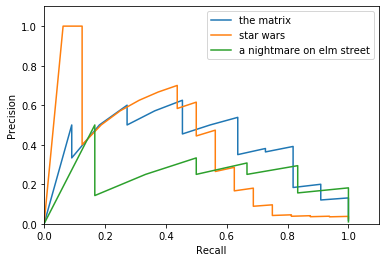

In [50]:
# Cosine Similarity Plot
plot_precision_recall(movie_sims_cos, [0,1.1], [0,1.1])

Looking at the cosine similarity plot above, make some observations about why you're seeing what you're seeing. What does the plot reveal about the performance of the cosine similarity method for the given queries? Include observations on what worked well, what didn't, and how you've arrived at these conclusions. 

<br>


<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;">Write your answer in the provided cell below</div>

1. we go from k=1 and go up, of course we can see the general pattern is that the more you retrieve, the better recall would be 
2. in terms of starwars, the retrieval engine worked fine. the first two retrievals are correct, so we see that generally the precision goes lower if we increase the documents.
3. for the other two movies, their matches weren't so great, but we can still see that after the initial few attempts, then the precision starts to go down and recall goes high. we can reasonably expect them to have the same pattern if given a larger dataset or a better retrieve model.

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;"></div>

## Question 5c (Free Response): Jaccard Similarity Plot Analysis

Run the code below to show the precision-recall curve for our three movie queries using jaccard similarity. 

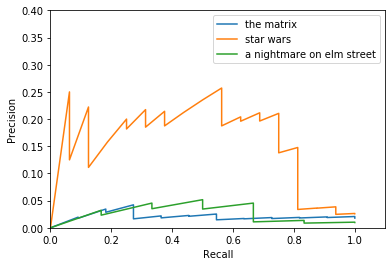

In [51]:
# Jaccard Similarity Plot
plot_precision_recall(movie_sims_jac, [0,1.1], [0,0.4])

Looking at the jaccard similarity plot above,  make some observations about why you're seeing what you're seeing. What does the plot reveal about the performance of the jaccard similarity method for the given queries? Include observations on what worked well, what didn't, and how you've arrived at these conclusions. 

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;">Write your answer in the provided cell below</div>

we know from the y-axis that this Jaccard similarity we have right now performs much worse than the cos-sim one. the matrix and a nightmare on elm street was performing so bad. maybe it's because it was a hard-to-define movie and not easily classified into categories.  
 And still the precision goes down when they reach high recall. But we can definitely see that the first few retrieved movies are so wrong - the precision is so low!

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;"></div>

## Question 5d (Free Response): Cosine Sim vs Jaccard Sim Plot Comparison

Now that you've observed the plots for both cosine similarity and jaccard similarity, please answer the following two questions:

1. Which system performs better, in general?
2. Which query was the most problematic in each case?

<br>

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;">Write your answer in the provided cell below</div>

of course the first one cos-sim worked better, as explained before.

i'd say matrix and nightmare those two all have some problems, but in general I think a nightmare on elm street is really problemtic.

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;"></div>

## Question 5e (Code Completion): Calculating F-score Values

Now that you have seen the precison-recall, we will calculate the F-score foreach of the queries and see if they reveal any new information. As a reminder, the formuala for calculating the F-score is given below.

$$F-score = \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}}$$ 

Note: If Precision or Recall is 0 we will just state that the fscore is 0.

In [52]:
def compute_fscore(precision, recall):
    """
    Returns lists of f-score values at different k values, where fscore[k] = the fscore@k
    
    Parameters
    ----------
    precision : np.ndarray
        numpy array of precision values at different k values, where precision[k] = the
        precision@k.
    recall : np.ndarray
        numpy array of recall values at different k values, where recall[k] = the
        recall@k.

    Returns
    -------
    np.ndarray
        Returns a numpy array of length equal to the length of the precision (and recall) parameter 
        array, where fscore[k] = the fscore@k.
    """
    fscore = np.zeros(len(precision))
    for k in range(1, len(precision)):
        fscore[k] = 2 * precision[k] * recall[k] / (precision[k] + recall[k])
    return fscore

In [53]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that precision_recall returns the correct output"""
query, rel_movs = queries[1]
ranked_movs = [m for m,_ in get_ranked_movies(query, movie_sims_cos)]
precision, recall = precision_recall(ranked_movs, rel_movs)
fscore = compute_fscore(precision, recall)

assert fscore[0] == 0
assert fscore.shape == (617,)
assert recall.shape == (617,)
assert sum(fscore) > 60 and sum(precision) < 100
assert fscore[300] > 0.08 and precision[300] < 0.09


In [54]:
def plot_fscore(matrix):
    """Plots the fscore curve given the similarity matrix
    
    Params: {matrix: np.ndarray}
    Returns: None
    """
    query, rel_movs = queries[1]
    ranked_movs = [m for m,_ in get_ranked_movies(query, movie_sims_cos)]

    for query, rel_movs in queries:
        ranked_movs = [m for m,_ in get_ranked_movies(query, matrix)] 
        precision, recall = precision_recall(ranked_movs, rel_movs)
        fscore = compute_fscore(precision, recall)
        plt.plot(range(1,len(fscore)+1), fscore)

    plt.xlabel("K")
    plt.ylabel("Fscore")
    plt.legend([q[0] for q in queries])

/Users/erlich_jaso/opt/anaconda3/envs/LangInfo/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


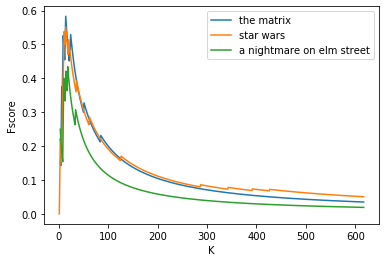

In [55]:
plot_fscore(movie_sims_cos)

/Users/erlich_jaso/opt/anaconda3/envs/LangInfo/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


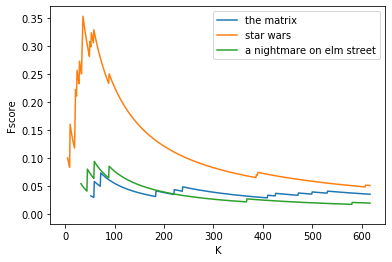

In [56]:
plot_fscore(movie_sims_jac)

## Question 5f (Free Response): Cosine Sim vs Jaccard Sim Fscore Plot Comparison

Now that you've observed the fscore plots for both cosine similarity and jaccard similarity, please answer the following three questions:

1. In what ways do the F-score curves provide more or different information about the retrievals compared to the precision-recall graphs?
2. Are there any queries for which the F-score curves suggest different rankings of movies than the precision-recall graphs? If so, which queries and what are the differences?
3. How would you interpret the shape of the F-score curves for a given query? What does a flat curve or a steeply increasing curve indicate about the rankings?

<br>

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;">Write your answer in the provided cell below</div>

1. F-score balances between retrieval and precision, so we can have a single-one criteria to evaluate the performance
2. so we may have seen that in the precision-recall graph seems like starwars is the highest, but in fact in fscore the matrix is even slightly higher at the peak value. So f score graph can really help us better interpret the result
3. first go high - then go down. we'll pick the peak value as our desired retrieved document sets, since it best balances between precision and recall. a flat curve means that it really doesn't make a large difference how many documents you are retreiving, and that it might not be a good method. on the other hand, a steep curve means that the performance reaches highest point - possibly just around the length of the ground truth - and it's doing a really good job.

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;"></div>

## Evaluating our rankings with Mean Average Precision

While precision/recall curves are a good tool to visualize how well our rankings are performing, in some contexts, it is ideal to come up with a single number that characterizes how well our ranking system is doing over all ground-truth queries. A commonly used statistic for ranking systems is _Mean Average Precision_. To compute this value, first, one must compute the average precision for each query and subsequent ranking output by the system. Next, one averages these values. We've filled in functions for both `average_precision` and `mean_average_precision` for you. At the end of this section, run the provided code, which will give you a single number that evaluates the performance of each ranking system.

In [57]:
def average_precision(ranking_in, relevant):
    '''
    Arguments:
        ranking_in: sorted ranking of movies, starting with the most most similar, and ending
        with the least similar.
        
        relevant: iterable of movies relevant to the original query
        
    Returns:
        average_precision: float corresponding to the AP statistic for this ranking and
        this set of relevant docuemnts.
    '''
    rel_rank = sorted([ranking_in.index(r)+1 for r in relevant])
    return np.mean([(i+1)*1./(r) for i, r in enumerate(rel_rank)])
    
    
def mean_average_precision(queries_in, sims_mat):
    '''
    Arguments:
        queries_in: a list of (query, [relevant documents]) pairs, representing the queries we
        want to evaluate our ranking system against
    
        sims_mat: a movie by movie numpy array, where sims_mat[i,j] = sims_mat[j,i] = the similarity
        of movies i and j
    
    Returns:
        mean_average_precision: float corresponding to the average AP statistic for the input queries
        and the similarity matrix
    '''
    rankings = [[movie_index_to_name[i] for i in np.argsort(sims_mat[movie_name_to_index[q],:])[::-1] if movie_index_to_name[i] != q]
                for q,_ in queries]
    aps = []
    for i, results in enumerate(rankings):
        ap = average_precision(results, queries_in[i][1])
        aps.append(ap)
        print("Query name:", queries_in[i][0], "//", "Avg. Precision: {:.3f}".format(ap))
    mean_avg_precision = 1.0 * sum(aps)/len(queries_in)
    print("[Mean Average Precision: {:.3f}]".format(mean_avg_precision))
    return mean_avg_precision

In [58]:
print("=== cosine_sim with tfidf features ===")
mean_average_precision(queries, movie_sims_cos)
print()
print("=== jacc_sim ===")
mean_average_precision(queries, movie_sims_jac)
print()

=== cosine_sim with tfidf features ===
Query name: the matrix // Avg. Precision: 0.449
Query name: star wars // Avg. Precision: 0.430
Query name: a nightmare on elm street // Avg. Precision: 0.311
[Mean Average Precision: 0.397]

=== jacc_sim ===
Query name: the matrix // Avg. Precision: 0.022
Query name: star wars // Avg. Precision: 0.193
Query name: a nightmare on elm street // Avg. Precision: 0.033
[Mean Average Precision: 0.083]



## Rocchio Algorithm

Great -- we have a baseline evaluation for how well our vector space tfidf information retrevial system does! Now, it is our job to do something better. Here, we will implement the Rocchio Algorithm and use it for pseudo relevance feedback.

This is Rocchio’s query update rule for relevance feedback:

$$\overrightarrow{{q}_1} = a * \overrightarrow{{q}_0} + b*\frac{1}{|D_r|}\sum_{d \in D_r}{\overrightarrow{d}}-c*\frac{1}{|D_{nr}|}\sum_{d \in D_{nr}}{\overrightarrow{d}}$$ 

In the above, $\overrightarrow{{q}_0}$ is the initial query, $\overrightarrow{{q}_1}$ is the updated query, $D_r$ is the set of relevant documents and $D_{nr}$ is the set of non-relevant documents. $a$, $b$, and $c$ are the update weights that correspond to the original query, the relevant queries, and the irrelevant queries, respectively. If after the update, there are negative values in $\overrightarrow{{q}_1}$, they are set to 0.

## Question 6 (Code Completion): Rocchio
Your job here is to implement the Rocchio Algorithm for relevance feedback. This function will test your understanding of how numpy arrays interact with variable types. For example, a + b where a is a python float and b is a numpy array will return a numpy array where each element of b has been shifted by a. While this particular function may or may not be needed to implement rocchio, it can be *very* helpful. 

In [59]:
def rocchio(query, relevant, irrelevant, input_doc_matrix, \
            movie_name_to_index,a=.3, b=.3, c=.8, clip = True):
    """Returns a vector representing the modified query vector. 
    
    Note: 
        If the `clip` parameter is set to True, the resulting vector should have 
        no negatve weights in it!
        
        Also, be sure to handle the cases where relevant and irrelevant are empty lists.
        
    Params: {query: String (the name of the movie being queried for),
             relevant: List (the names of relevant movies for query),
             irrelevant: List (the names of irrelevant movies for query),
             input_doc_matrix: Numpy Array,
             movie_name_to_index: Dict,
             a,b,c: floats (weighting of the original query, relevant queries,
                             and irrelevant queries, respectively),
             clip: Boolean (whether or not to clip all returned negative values to 0)}
    Returns: Numpy Array 
    """
    
    result = np.zeros(input_doc_matrix.shape[1])
    result += a * input_doc_matrix[movie_name_to_index[query]]
    if len(relevant) > 0:
        result += b * np.mean(input_doc_matrix[[movie_name_to_index[m] for m in relevant]], axis=0)
    if len(irrelevant) > 0:
        result -= c * np.mean(input_doc_matrix[[movie_name_to_index[m] for m in irrelevant]], axis=0)
    if clip:
        result = np.clip(result, 0, None)
    return result

Before we use the Rocchio algorithm for understanding pseduo-relevance feedback, we'll do a reality check and make sure that our implementation can improve performance on our existing queries. To augment our analysis, movie guru Ilan has also provided you with a list of irrelevant queries for each of our test queries. You'll notice that the irrelevant queries for each of the test queries are quite similar. This is because it's much more common for a pair of movies to be irrelevant, rather than relevant. In fact, it's not uncommon that *all* queries that are not relevant are *assumed to be irrelevant.*

Here, though, we'll just use this small subset.

In [60]:
irrelevant  = [('the matrix', ['lone star',
                               '2001: a space odyssey',
                               'wall street',
                               'the elephant man',
                               'eternal sunshine of the spotless mind',
                              'suburbia',
                               'taking sides',
                               'lake placid'
                              ]),
               ('star wars',  ['lone star',
                               '2001: a space odyssey',
                               'wall street',
                               'the elephant man',
                               'eternal sunshine of the spotless mind',
                              'suburbia',
                              'taking sides',
                              'lake placid']),
               ('a nightmare on elm street', ['lone star',
                               '2001: a space odyssey',
                               'wall street',
                               'the elephant man',
                               'eternal sunshine of the spotless mind',
                                'suburbia',
                                'taking sides',
                                'lake placid']),]


In [61]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that rocchio returns the correct output"""
query_vector = rocchio("the matrix",[],irrelevant[0][1],doc_by_vocab,movie_name_to_index)
query_vector2 = rocchio("star wars",[],irrelevant[1][1],doc_by_vocab,movie_name_to_index)
assert type(query_vector) == np.ndarray
assert type(query_vector2) == np.ndarray
assert sum(query_vector) > 3 and sum(query_vector) < 4
assert sum(query_vector2) > 2 and sum(query_vector2) < 3

## Question 7 (Code Completion): Leveraging Rocchio
Your job is to leverage rocchio to return the top 10 highest ranked movies for each query, where the query vector is updated with rocchio. 
Return the dictionary with in the following format:
```
{'the matrix': [movie1,movie2,...,movie10],
 'star wars': [movie1,movie2,...,movie10],
 'a nightmare on elm street': [movie1,movie2,...,movie10]}
```


Note that the query itself should be excluded from the rankings.

In [66]:
def cosine_sim(vec1, vec2):
    """Returns the cosine similarity between two vectors.
    Note: You can assume that vec1 and vec2 are both numpy arrays.
    """
    return np.dot(vec1, vec2) / (LA.norm(vec1) * LA.norm(vec2))

def top_10_with_rocchio(relevant_in, irrelevant_in, input_doc_matrix, \
            movie_name_to_index,movie_index_to_name,input_rocchio):
    """Returns a dictionary in the following format:
    {
        'the matrix': [movie1,movie2,...,movie10],
        'star wars': [movie1,movie2,...,movie10],
        'a nightmare on elm street': [movie1,movie2,...,movie10]
    }
    
    Note: 
        You can assume that relevant_in[i][0] = irrelevant_in[i][0] 
        (i.e. the queries are in the same order). 
        
        You should use the default rocchio parameters.
        
        You should NOT return the query itself in the list of most common
        movies.
        
    Parameters
    ----------
    relevant_in : (query: str, [relevant documents]: str list) list 
        List of tuples of the form:
        tuple[0] = name of movie being queried (str), 
        tuple[1] = list of names of the relevant movies to the movie being queried (str list).
    irrelevant_in : (query: str, [irrelevant documents]: str list) list 
        The same format as relevant_in except tuple[1] contains list of irrelevant movies instead.
    input_doc_matrix : np.ndarray
        The term document matrix of the movie transcripts. input_doc_mat[i][j] is the tfidf
        of the movie i for the word j.
    movie_name_to_index : dict
         A dictionary linking the movie name (Key: str) to the movie index (Value: int). 
         Ex: {'movie_0': 0, 'movie_1': 1, .......}
    movie_index_to_name : dict
         A dictionary linking the movie index (Key: int) to the movie name (Value: str). 
         Ex: {0:'movie_0', 1:'movie_1', .......}
    input_rocchio: function
        A function implementing the rocchio algorithm. Refer to Q6 for the function 
        input parameters. Make sure you use the function's default parameters as 
        much as possible.
        
    Returns
    -------
    dict
        Returns the top ten highest ranked movies for each query in the format described above.
    """
    rankings = {}
    for i, (query, relevant) in enumerate(relevant_in):
        irrelevant = irrelevant_in[i][1]
        query_vector = input_rocchio(query, relevant, irrelevant, input_doc_matrix, \
            movie_name_to_index)
        
        sims = [] 
        for movie in movie_index_to_name.values():
            if movie != query:
                sims.append((movie, cosine_sim(query_vector, input_doc_matrix[movie_name_to_index[movie]])))
        sims.sort(key=lambda x: x[1], reverse=True)
        rankings[query] = [s[0] for s in sims[:10]]
    return rankings

In [67]:
movie_recommend_with_rocchio = top_10_with_rocchio(queries, irrelevant,\
                                                  doc_by_vocab,movie_name_to_index,\
                                                  movie_index_to_name,rocchio)
for k,v in movie_recommend_with_rocchio.items():
    print(k)
    print("="*len(k))
    [print(a) for a in v]
    print("")

the matrix
the x files
xxx
smokin' aces
metropolis
pitch black
suspect zero
fear and loathing in las vegas
an officer and a gentleman
clerks.
out of sight

star wars
star wars: the empire strikes back
star wars: episode vi - return of the jedi
star trek: nemesis
star trek: first contact
star trek: generations
star trek: insurrection
cool hand luke
star trek vi: the undiscovered country
star trek: the motion picture
star trek v: the final frontier

a nightmare on elm street
a nightmare on elm street 3: dream warriors
a nightmare on elm street part 2: freddy's revenge
a nightmare on elm street: the dream child
new nightmare
hellraiser: hellseeker
jerry maguire
little nicky
cherry falls
cruel intentions
drop dead gorgeous



In [68]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that top_10_with_rocchio returns the correct output"""
assert type(movie_recommend_with_rocchio) == dict
assert "the x files" in movie_recommend_with_rocchio["the matrix"]
assert "star wars: the empire strikes back" in movie_recommend_with_rocchio["star wars"]
assert "a nightmare on elm street 3: dream warriors" in \
    movie_recommend_with_rocchio["a nightmare on elm street"]

## Question 7b (Code Completion): Leveraging Rocchio
Your job is to implement `mean_average_precision_rocchio` below, to compute MAP using the Rocchio-updated query vectors.

Your function should call `rocchio` and `average_precision`.

In [75]:
def mean_average_precision_rocchio(relevant_in, irrelevant_in, input_doc_matrix, \
            movie_name_to_index, movie_index_to_name, input_rocchio):
    """Returns a float corresponding to the mean AP statistic for the Rocchio-updated input queries
        and the similarity matrix
    Note: 
        You can assume that relevant_in[i][0] = irrelevant_in[i][0] 
        (i.e. the queries are in the same order). 
        
        You should use the default rocchio parameters.
        
        You should NOT include the query itself in the list of most common
        movies.
        
    Parameters
    ----------
    relevant_in : (query: str, [relevant documents]: str list) list 
        List of tuples of the form:
        tuple[0] = name of movie being queried (str), 
        tuple[1] = list of names of the relevant movies to the movie being queried (str list).
    irrelevant_in : (query: str, [irrelevant documents]: str list) list 
        The same format as relevant_in except tuple[1] contains list of irrelevant movies instead.
    input_doc_matrix : np.ndarray
        The term document matrix of the movie transcripts. input_doc_mat[i][j] is the tfidf
        of the movie i for the word j.
    movie_name_to_index : dict
         A dictionary linking the movie name (Key: str) to the movie index (Value: int). 
         Ex: {'movie_0': 0, 'movie_1': 1, .......}
    movie_index_to_name : dict
         A dictionary linking the movie index (Key: int) to the movie name (Value: str). 
         Ex: {0:'movie_0', 1:'movie_1', .......}
    input_rocchio: function
        A function implementing the rocchio algorithm. Refer to Q6 for the function 
        input parameters. Make sure you use the function's default parameters as 
        much as possible.
        
    Returns
    -------
    float
        Returns a float corresponding to the mean AP statistic for the Rocchio-updated input queries
        and the similarity matrix
    """
    aps = []
    for i, (query, relevant) in enumerate(relevant_in):
        irrelevant = irrelevant_in[i][1]
        query_vector = input_rocchio(query, relevant, irrelevant, input_doc_matrix, \
            movie_name_to_index)
        
        sims = [] 
        for movie in movie_index_to_name.values():
            if movie != query:
                sims.append((movie, cosine_sim(query_vector, input_doc_matrix[movie_name_to_index[movie]])))
        sims.sort(key=lambda x: x[1], reverse=True)
        aps.append(average_precision( [s[0] for s in sims] , relevant))
    
    return np.mean(aps)

In [76]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that mean_average_precision_rocchio returns the correct output"""
mean_average_precision = mean_average_precision_rocchio(queries, irrelevant,\
                                                  doc_by_vocab,movie_name_to_index,\
                                                  movie_index_to_name,rocchio)
assert mean_average_precision > 0.60

The Rocchio addition to the system clearly adds a much larger level of precision as you are doing query
modification that is based on relevant and irrelevant documents that are passed in. With the revision
of this query this increases the search engine's recall, as well as the precision.

**Note:**
While our performance increased, it shouldn't be surprising that this is the case. At a high level, here is what we did: we took our original query vectors and moved them slightly closer to the "ground truth" relevant documents, and then used mean average precision to find that, indeed, the new query vector was closer to the true "ground truth" vectors. 

## Question 8 (Free Response): Biggest Losses

However, it is fun to see what words were given more or less weight for a given query according to the Rocchio modified query vector. Understand and run the following code:

In [77]:
q_o = doc_by_vocab[movie_name_to_index[queries[0][0]],:]
q_m = rocchio(queries[0][0], queries[0][1], irrelevant[0][1],doc_by_vocab,movie_name_to_index)
diffs = q_m-q_o
args_diffs = np.argsort(diffs)
losses = args_diffs[:10]
print("Biggest losses:")
for l in losses:
    print("{}:{:.3f}".format(index_to_vocab[l], diffs[l]))

Biggest losses:
tank:-0.264
operator:-0.144
agent:-0.133
exit:-0.128
program:-0.104
believed:-0.099
world:-0.096
goddamnit:-0.094
choice:-0.082
path:-0.078


In the cell below, explain what the code is doing and what the findings show

<br>

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;">Write your answer in the provided cell below</div>

In [80]:
queries[0]

('the matrix',
 ['the bourne supremacy',
  'being john malkovich',
  'smoke',
  'erin brockovich',
  'an officer and a gentleman',
  "smokin' aces",
  'pitch black',
  'out of sight',
  'clerks.',
  'xxx',
  'the x files'])

In [82]:
irrelevant[0]

('the matrix',
 ['lone star',
  '2001: a space odyssey',
  'wall street',
  'the elephant man',
  'eternal sunshine of the spotless mind',
  'suburbia',
  'taking sides',
  'lake placid'])

this function is doing this:
1. first we have an original vector q_o, and then a modified vector q_m
2. we apply the differnce and of course there is some word that has changed a lot and some hasn't.
3. Those listed words are those that appeared to be relevant and unique to this movie but infact does not.  Maybe they are also frequent in totally irrelevant movies and are absent from movies that are actually related.
4. In this example, well it turns out that words like 'tank' is not so relevant. And what seemed like a reasonable word in the matrix like 'agent'(smith), world, believed, path, choice (well ain't this movie all about these), they might not be so unique as we thought. they are just equally likely to appear in 'eternal sunshine of the spotless mind' (O i love that one) and 'taking sides' (you can tell it's gonna have a lot of choices just from the title)

<div style="border-bottom: 4px solid #AAA; padding-bottom: 6px; font-size: 16px; font-weight: bold;"></div>